This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [7]:
# Ajout DC
# La ligne suivante est inutile dans Google Colab
# !pip install keras keras-hub --upgrade -q

In [8]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [9]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Interpreting what ConvNets learn

### Visualizing intermediate activations

In [10]:
from google.colab import files

# You can use this to load the file
# "convnet_from_scratch_with_augmentation.keras"
# you obtained in the last chapter.
files.upload()

{}

In [11]:
import keras
model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras"
)
model.summary(line_length=80)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)        │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)           │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)                │ (None, 178, 178, 32)     │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)    │ (None, 89, 89, 32)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)                │ (None, 87, 87, 64)       │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)    │ (None, 43, 43, 64)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)                │ (None, 41, 41, 128)      │        73,856 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)    │ (None, 20, 20, 128)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)                │ (None, 18, 18, 256)      │       295,168 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)    │ (None, 9, 9, 256)        │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)                │ (None, 7, 7, 512)        │     1,180,160 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling2d_3        │ (None, 512)              │             0 │
│ (GlobalAveragePooling2D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout (Dropout)                 │ (None, 512)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 1)                │           513 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 4,707,269 (17.96 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,138,180 (11.97 MB)

In [12]:
import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step


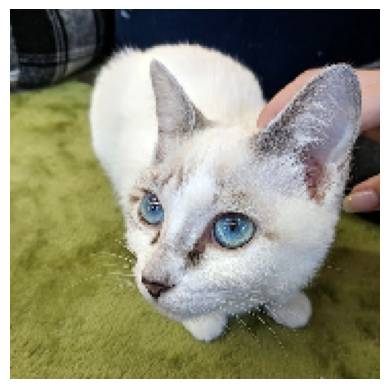

In [13]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [14]:
from keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [15]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [16]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


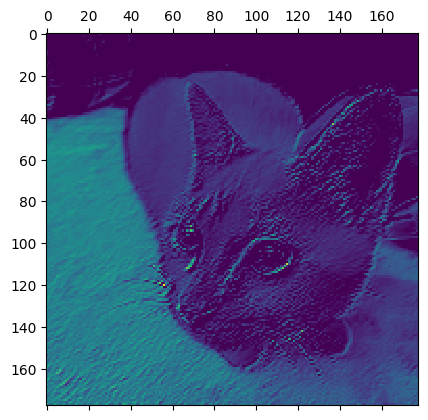

In [17]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

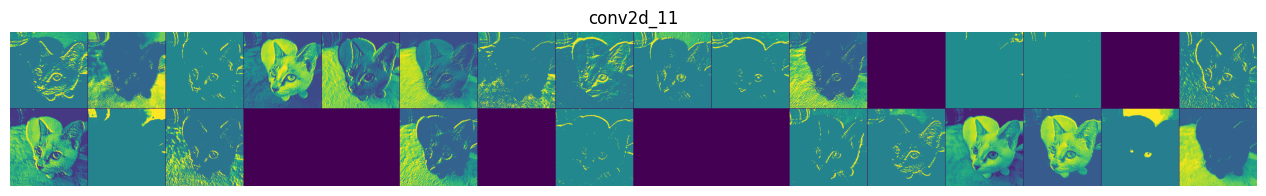

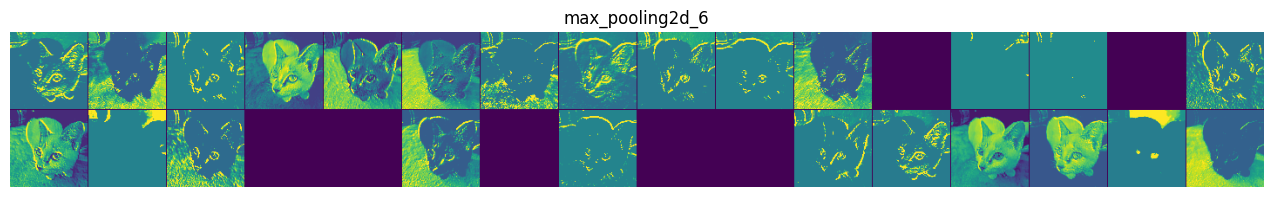

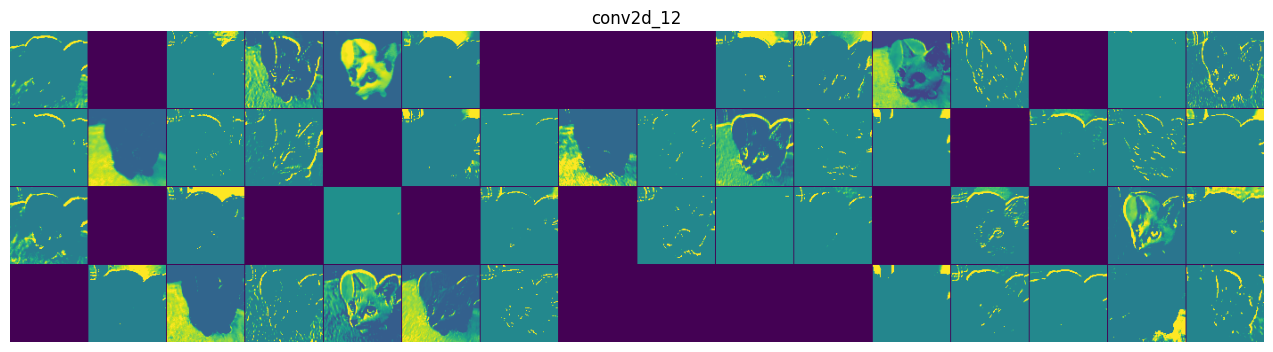

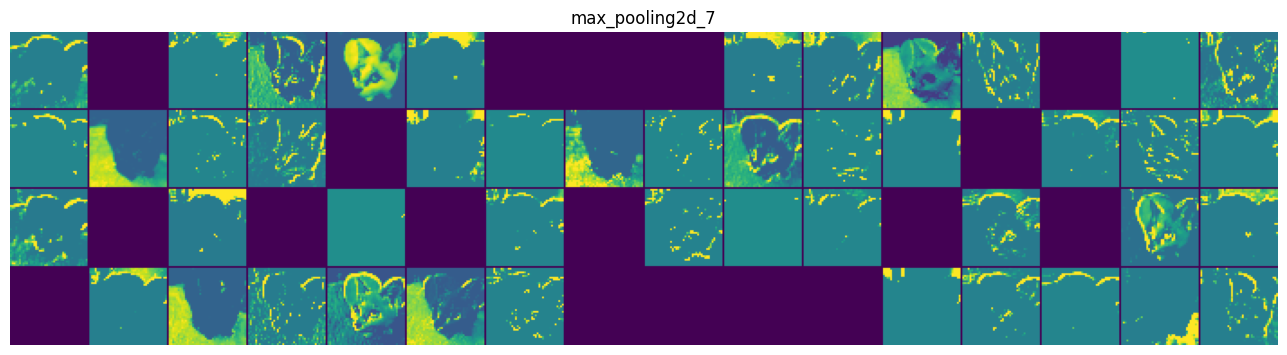

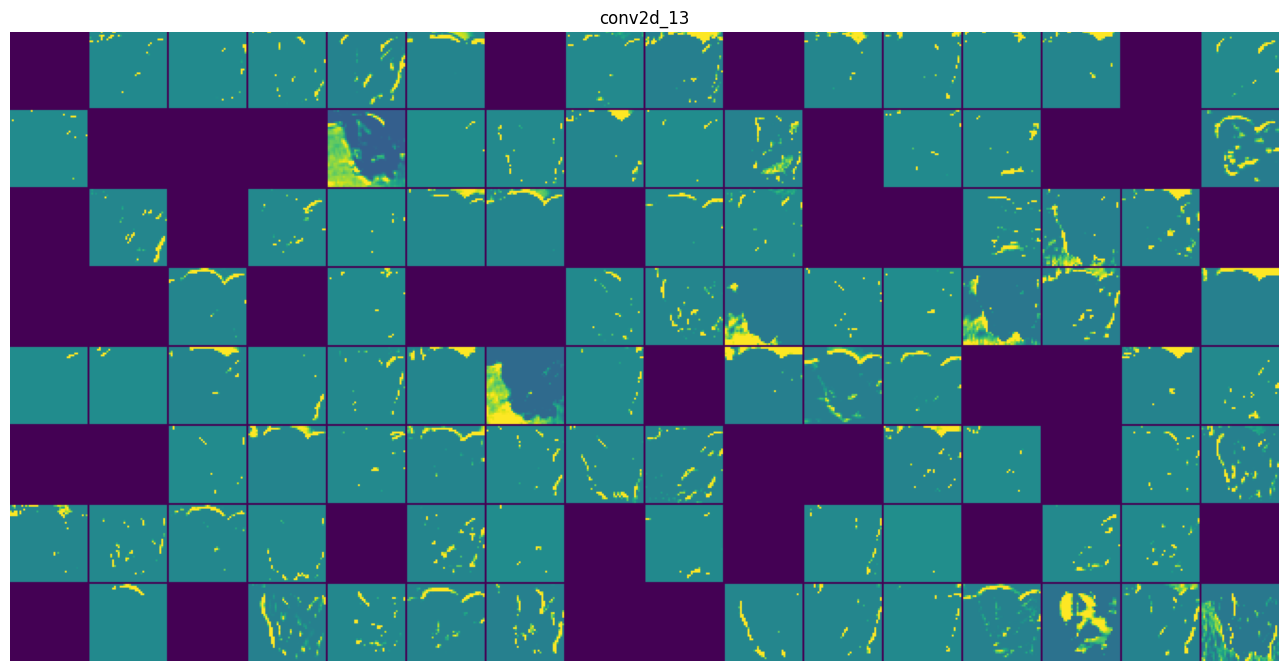

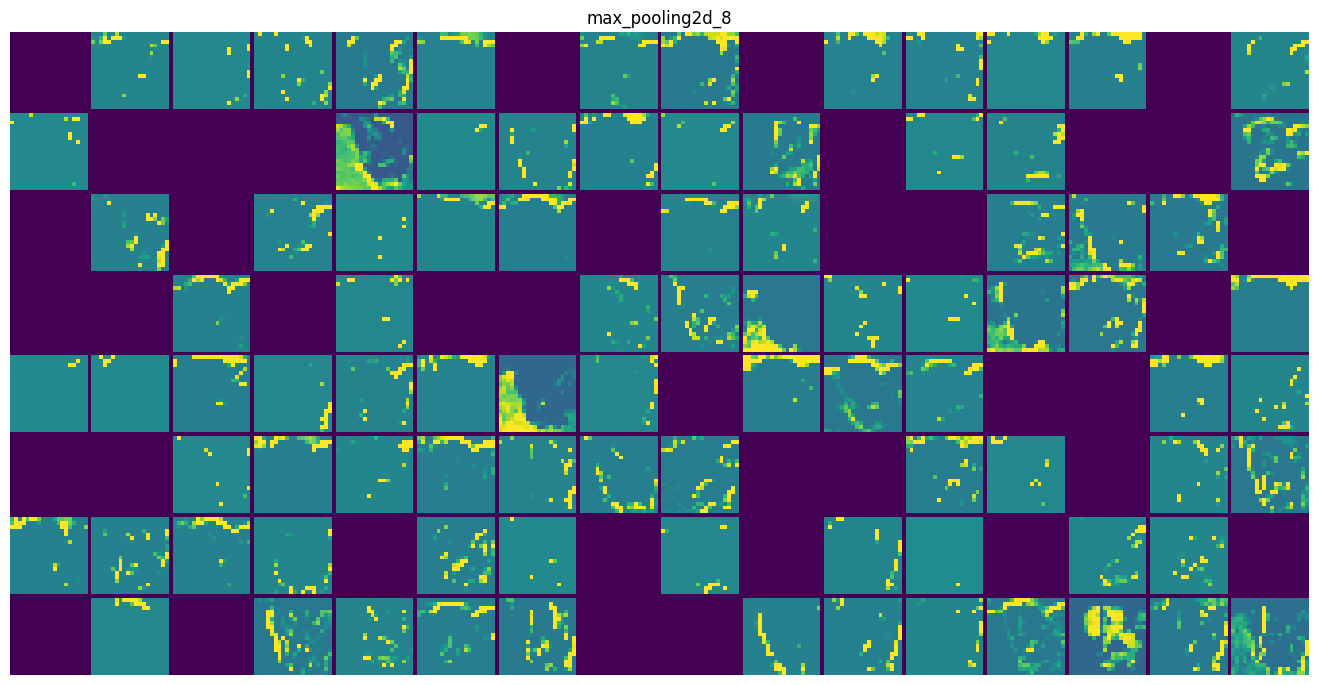

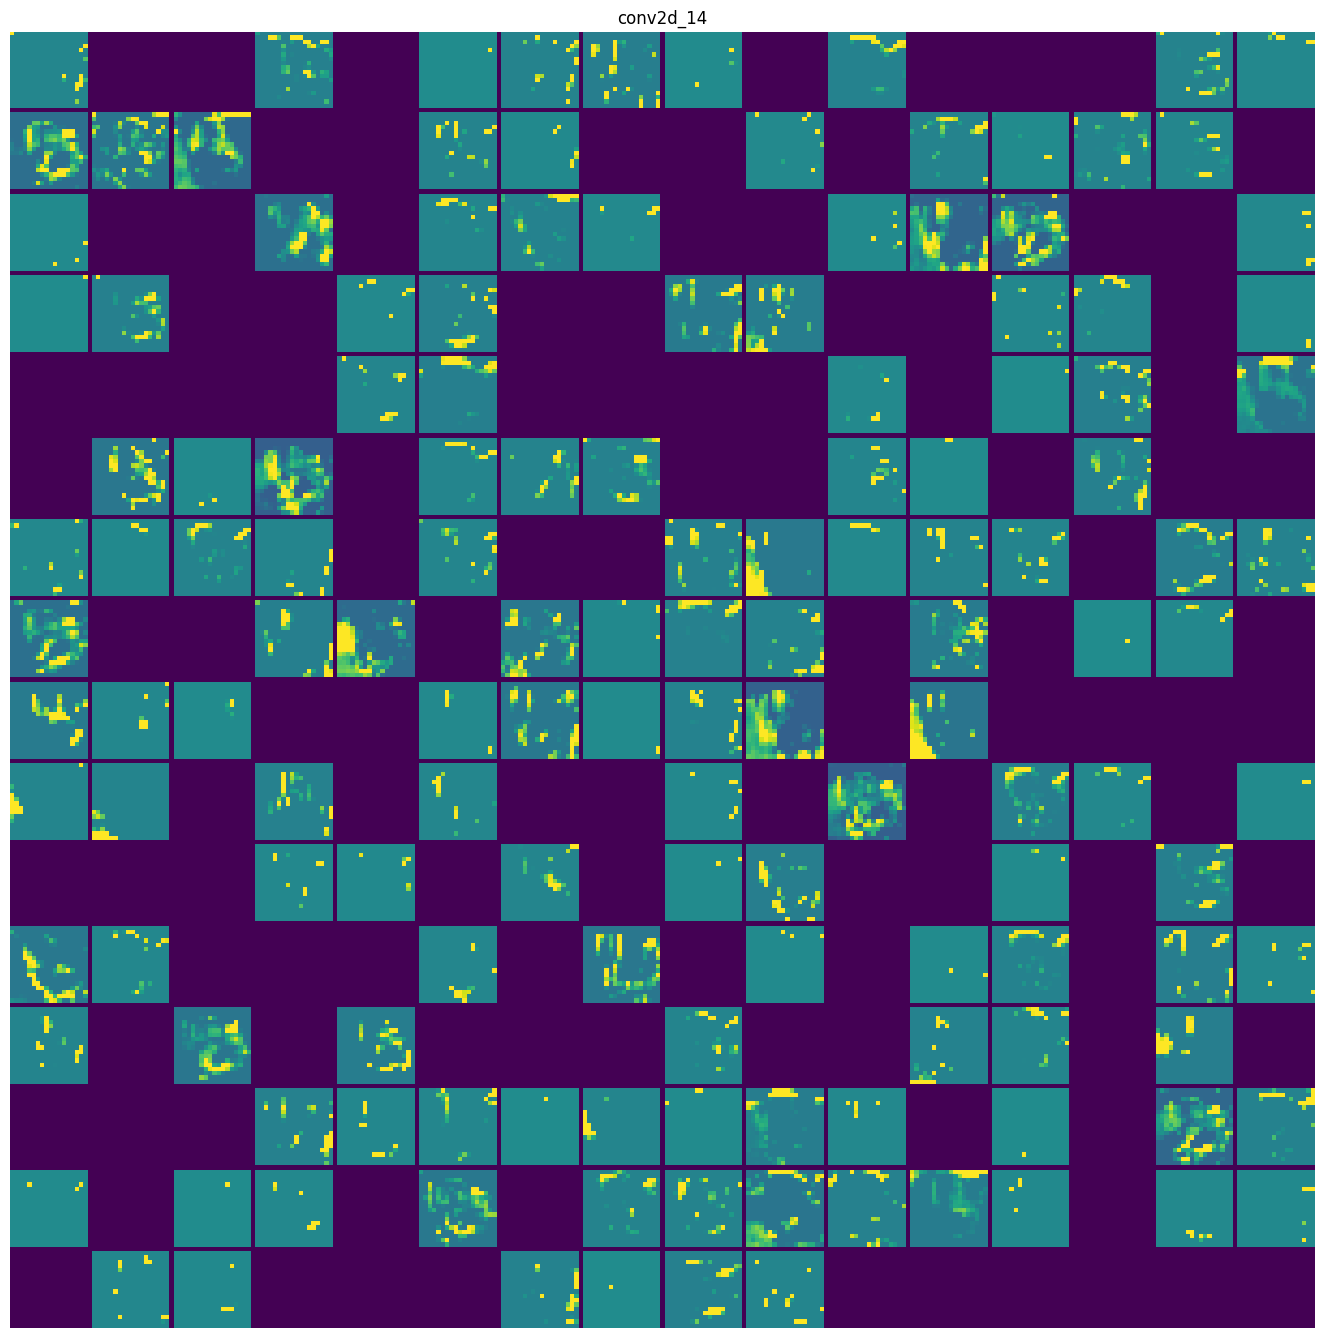

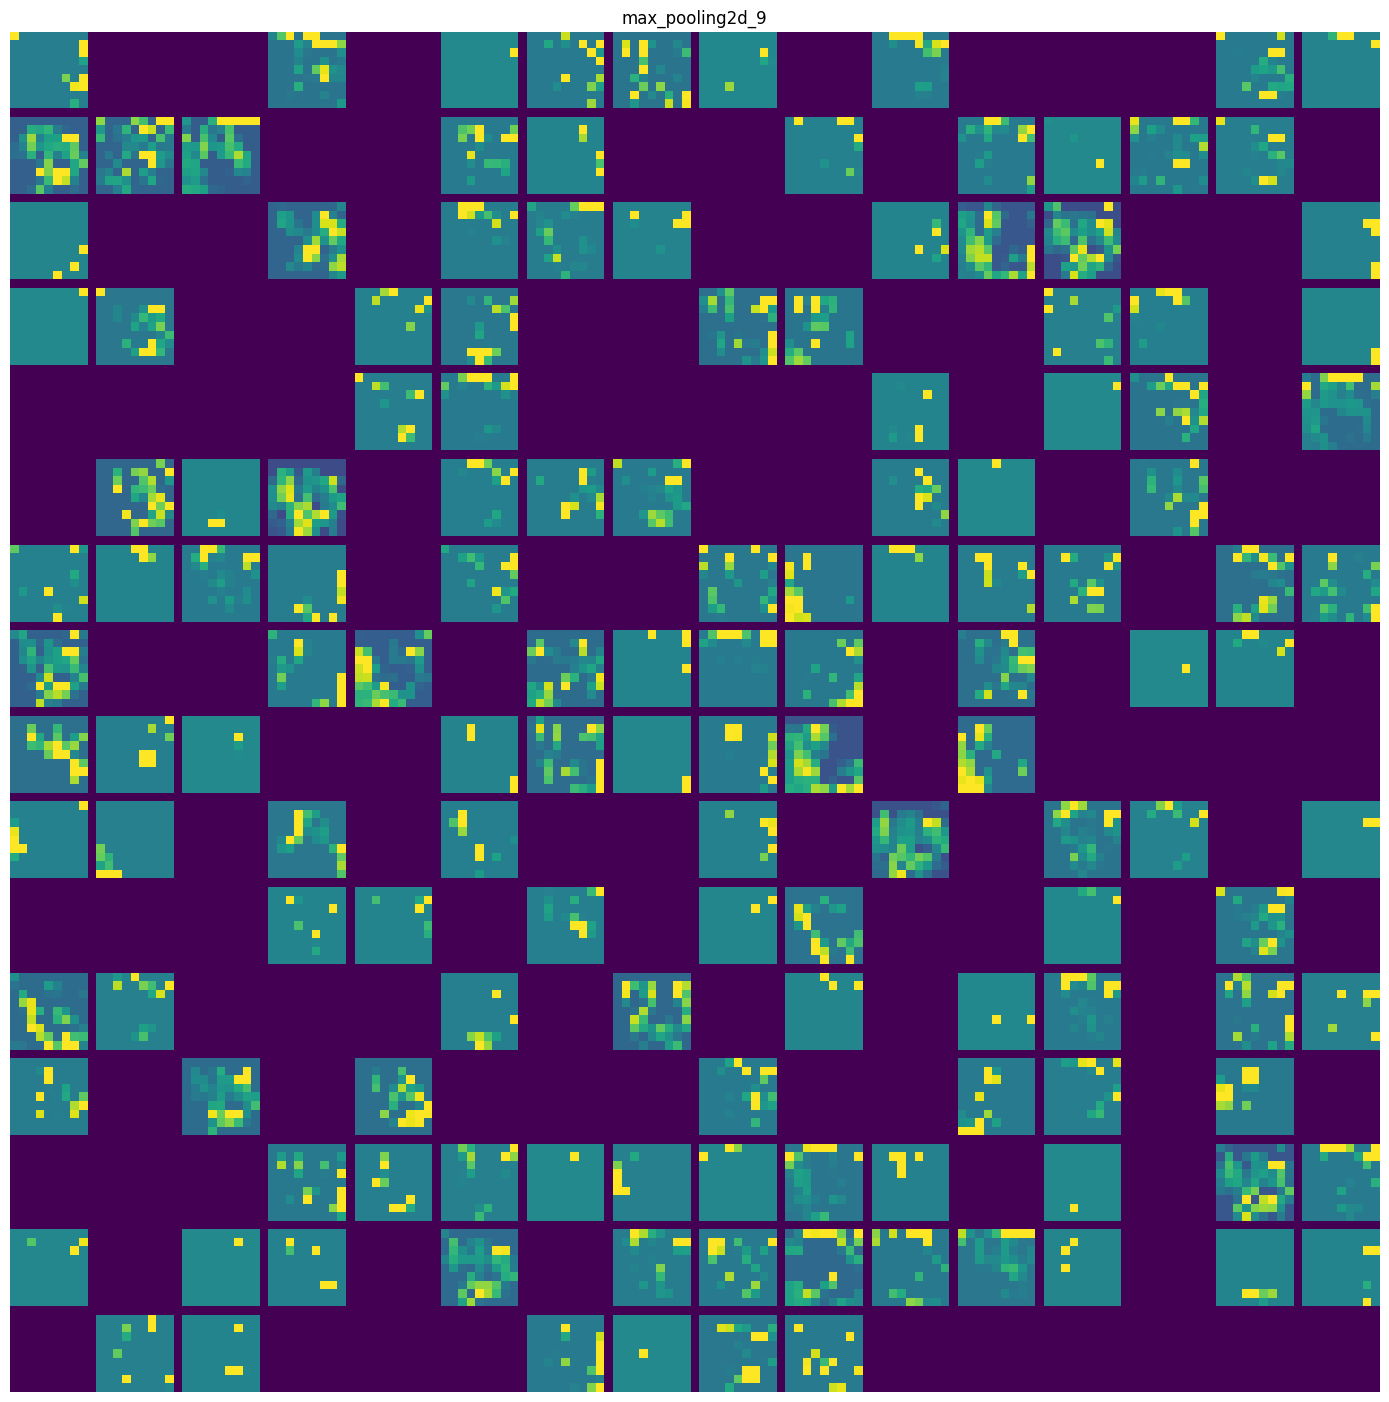

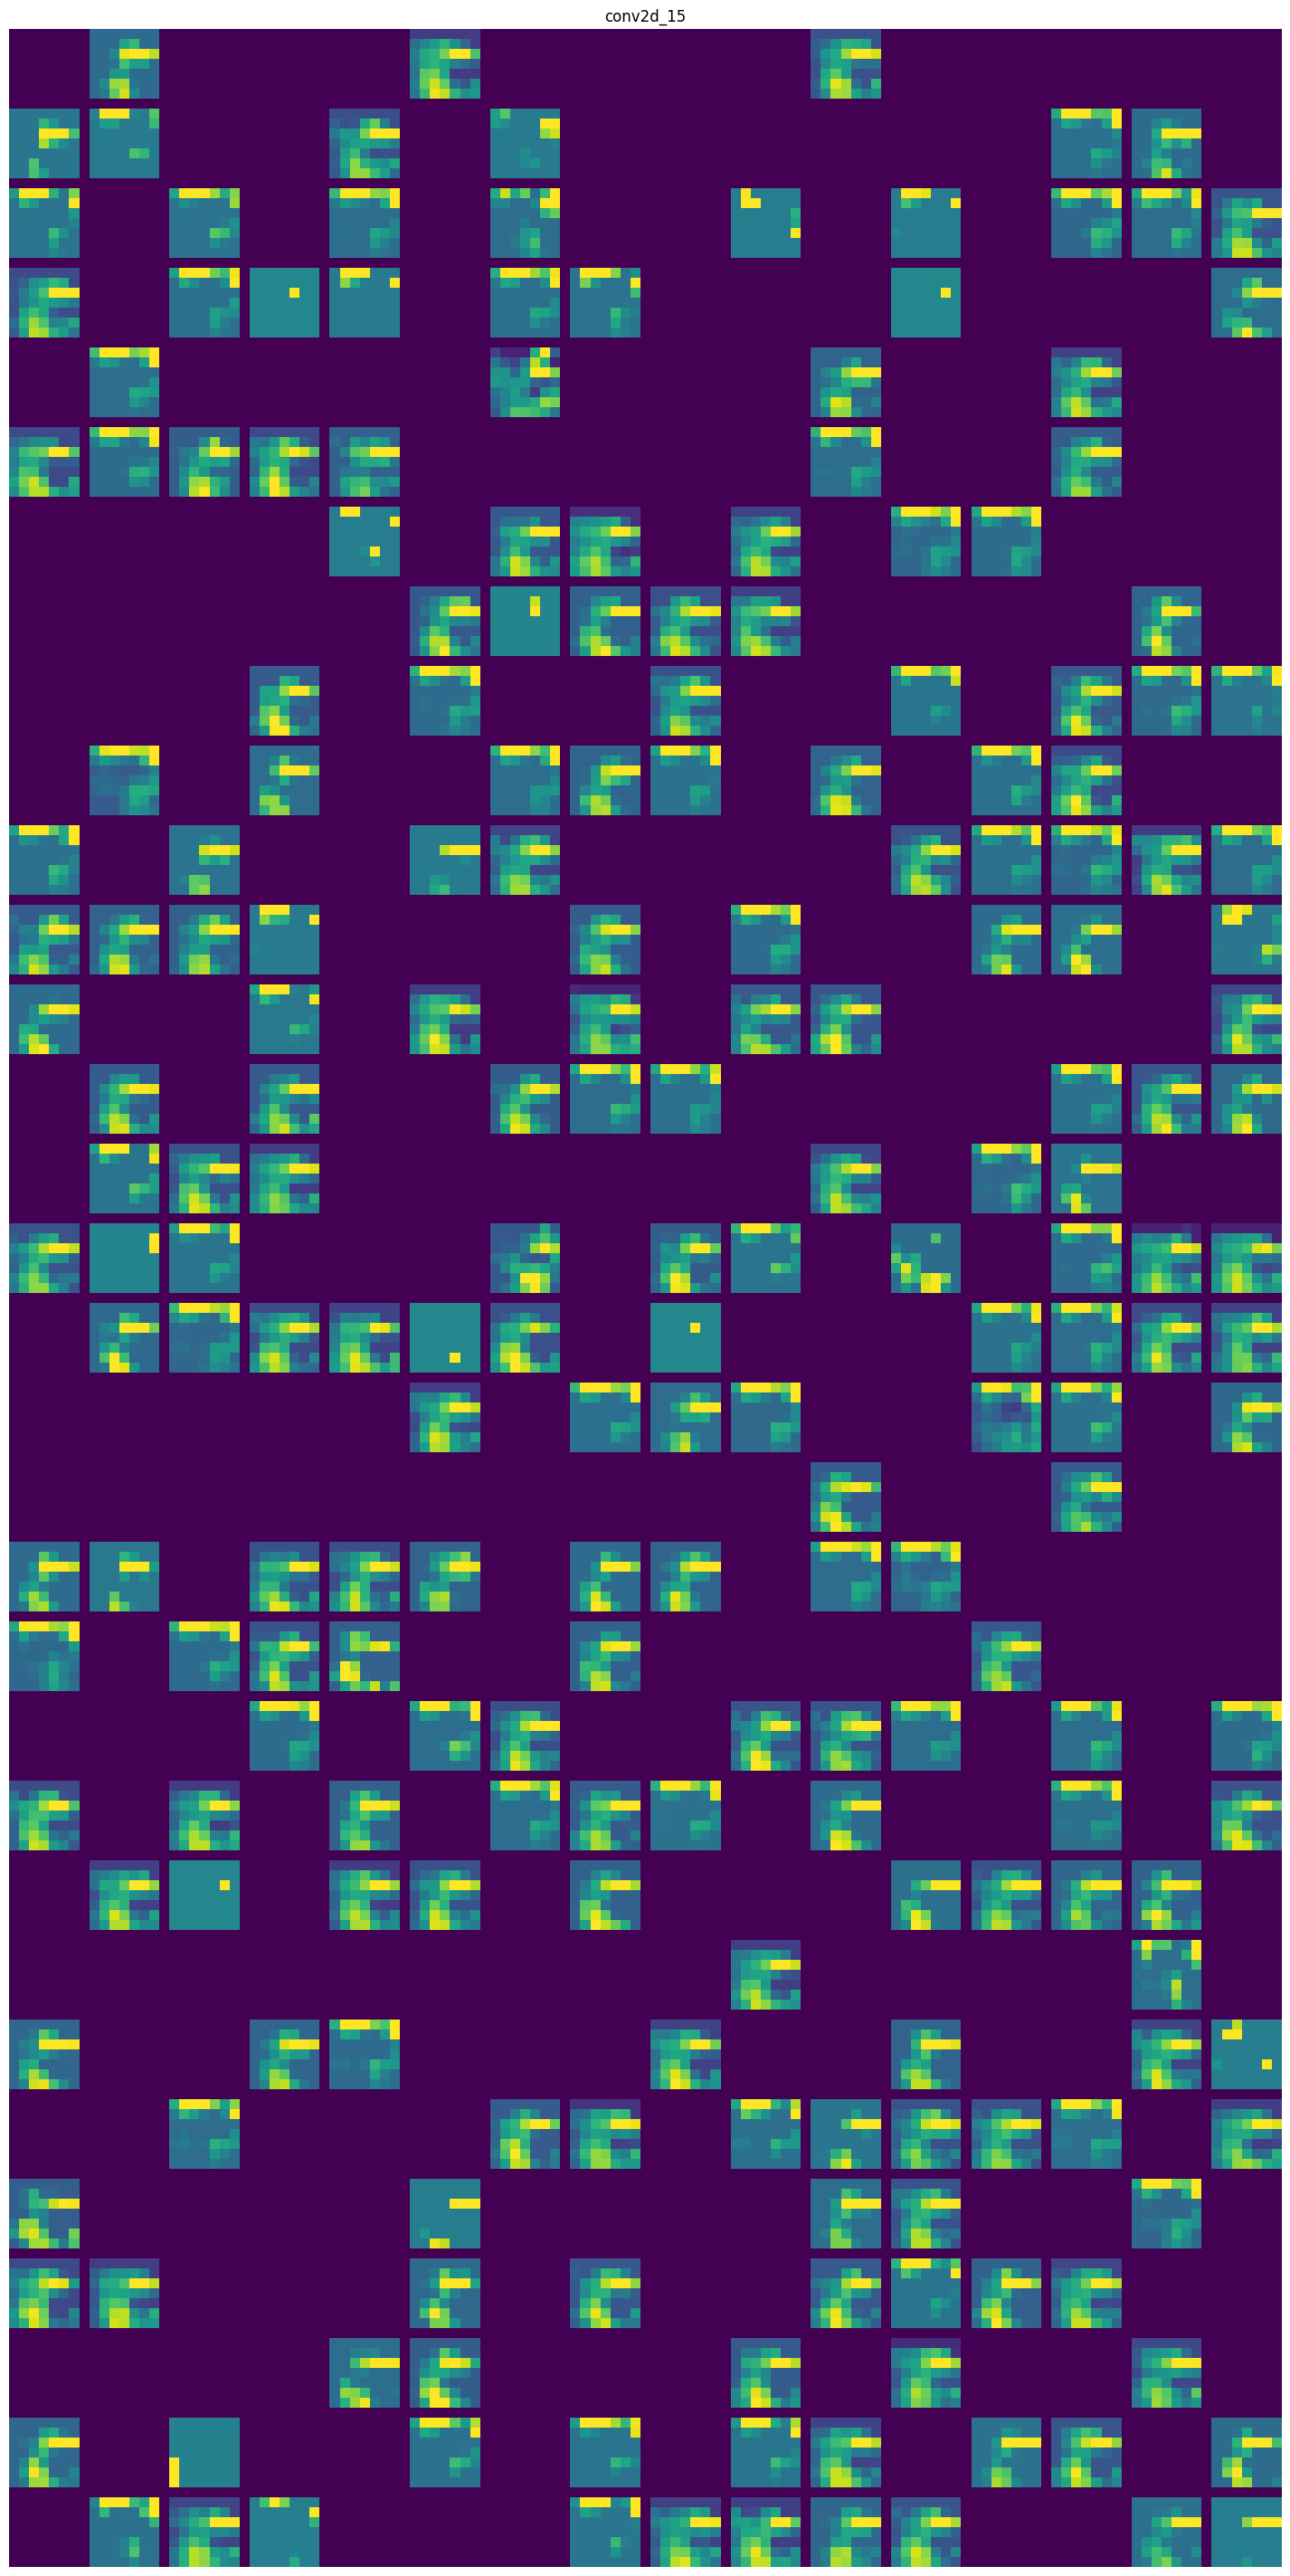

In [18]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(
        ((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1)
    )
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row,
            ] = channel_image
    scale = 1.0 / size
    plt.figure(
        figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])
    )
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing ConvNet filters

In [19]:
import keras_hub

model = keras_hub.models.Backbone.from_preset(
    "xception_41_imagenet",
)
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "xception_41_imagenet",
    image_size=(180, 180),
)

In [20]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
block2_residual_conv
block3_sepconv1
block3_sepconv2
block3_residual_conv
block4_sepconv1
block4_sepconv2
block4_residual_conv
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
block13_residual_conv
block14_sepconv1
block14_sepconv2


In [21]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [22]:
activation = feature_extractor(preprocessor(img_tensor))

In [23]:
from keras import ops

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return ops.mean(filter_activation)

#### Gradient ascent in TensorFlow

In [24]:
%%backend tensorflow
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = ops.normalize(grads)
    image += learning_rate * grads
    return image

This cell requires the tensorflow backend. To run it, change KERAS_BACKEND to "tensorflow" at the top of the notebook, restart the runtime, and rerun the notebook.


#### Gradient ascent in PyTorch

In [25]:
%%backend torch
import torch

def gradient_ascent_step(image, filter_index, learning_rate):
    image = image.clone().detach().requires_grad_(True)
    loss = compute_loss(image, filter_index)
    loss.backward()
    grads = image.grad
    grads = ops.normalize(grads)
    image = image + learning_rate * grads
    return image

This cell requires the torch backend. To run it, change KERAS_BACKEND to "torch" at the top of the notebook, restart the runtime, and rerun the notebook.


#### Gradient ascent in JAX

In [26]:
%%backend jax
import jax

grad_fn = jax.grad(compute_loss)

@jax.jit
def gradient_ascent_step(image, filter_index, learning_rate):
    grads = grad_fn(image, filter_index)
    grads = ops.normalize(grads)
    image += learning_rate * grads
    return image

#### The filter visualization loop

In [27]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.0
    image = keras.random.uniform(
        minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3)
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0]

In [28]:
def deprocess_image(image):
    image -= ops.mean(image)
    image /= ops.std(image)
    image *= 64
    image += 128
    image = ops.clip(image, 0, 255)
    image = image[25:-25, 25:-25, :]
    image = ops.cast(image, dtype="uint8")
    return ops.convert_to_numpy(image)

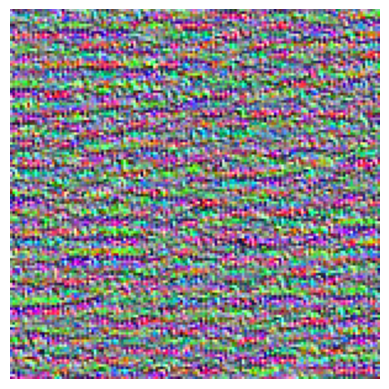

In [29]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [30]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

margin = 5
n = 8
box_width = img_width - 25 * 2
box_height = img_height - 25 * 2
full_width = n * box_width + (n - 1) * margin
full_height = n * box_height + (n - 1) * margin
stitched_filters = np.zeros((full_width, full_height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (box_width + margin) * i : (box_width + margin) * i + box_width,
            (box_height + margin) * j : (box_height + margin) * j + box_height,
            :,
        ] = image

keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

### Visualizing heatmaps of class activation

In [31]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg",
)
img = keras.utils.load_img(img_path)
img_array = np.expand_dims(img, axis=0)

733657/733657 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [32]:
model = keras_hub.models.ImageClassifier.from_preset(
   "xception_41_imagenet",
   activation="softmax",
)
preds = model.predict(img_array)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


(1, 1000)

In [33]:
keras_hub.utils.decode_imagenet_predictions(preds)

[[('African_elephant', 0.9032995700836182),
  ('tusker', 0.05492115393280983),
  ('Indian_elephant', 0.016380634158849716),
  ('triceratops', 0.0002968235348816961),
  ('Mexican_hairless', 0.00018846892635338008)]]

In [34]:
np.argmax(preds[0])

np.int64(386)

In [35]:
img_array = model.preprocessor(img_array)

In [36]:
last_conv_layer_name = "block14_sepconv2_act"
last_conv_layer = model.backbone.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [37]:
classifier_input = last_conv_layer.output
x = classifier_input
for layer_name in ["pooler", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

#### Getting the gradient of the top class: TensorFlow version

In [38]:
%%backend tensorflow
import tensorflow as tf

def get_top_class_gradients(img_array):
    last_conv_layer_output = last_conv_layer_model(img_array)
    with tf.GradientTape() as tape:
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = ops.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    return grads, last_conv_layer_output

grads, last_conv_layer_output = get_top_class_gradients(img_array)
grads = ops.convert_to_numpy(grads)
last_conv_layer_output = ops.convert_to_numpy(last_conv_layer_output)

This cell requires the tensorflow backend. To run it, change KERAS_BACKEND to "tensorflow" at the top of the notebook, restart the runtime, and rerun the notebook.


#### Getting the gradient of the top class: PyTorch version

In [39]:
%%backend torch
def get_top_class_gradients(img_array):
    last_conv_layer_output = last_conv_layer_model(img_array)
    last_conv_layer_output = (
        last_conv_layer_output.clone().detach().requires_grad_(True)
    )
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = ops.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    top_class_channel.backward()
    grads = last_conv_layer_output.grad
    return grads, last_conv_layer_output

grads, last_conv_layer_output = get_top_class_gradients(img_array)
grads = ops.convert_to_numpy(grads)
last_conv_layer_output = ops.convert_to_numpy(last_conv_layer_output)

This cell requires the torch backend. To run it, change KERAS_BACKEND to "torch" at the top of the notebook, restart the runtime, and rerun the notebook.


#### Getting the gradient of the top class: JAX version

In [40]:
%%backend jax
import jax

def loss_fn(last_conv_layer_output):
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = ops.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    return top_class_channel[0]

grad_fn = jax.grad(loss_fn)

def get_top_class_gradients(img_array):
    last_conv_layer_output = last_conv_layer_model(img_array)
    grads = grad_fn(last_conv_layer_output)
    return grads, last_conv_layer_output

grads, last_conv_layer_output = get_top_class_gradients(img_array)
grads = ops.convert_to_numpy(grads)
last_conv_layer_output = ops.convert_to_numpy(last_conv_layer_output)

#### Displaying the class activation heatmap

In [41]:
pooled_grads = np.mean(grads, axis=(0, 1, 2))
last_conv_layer_output = last_conv_layer_output[0].copy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

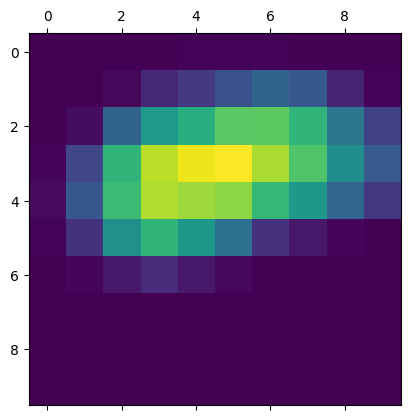

In [42]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

/tmp/ipython-input-1358311572.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


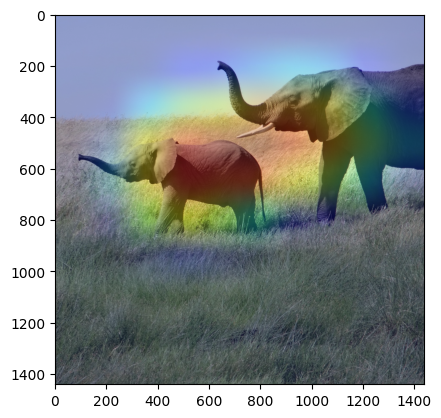

In [43]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)

### Visualizing the latent space of a ConvNet